## Topic: Image Classification using CNN (Convolution Neural Networks) and with dataset African Animals

Student: Dzhumagalieva Sara, 
Group: IT2-2003

In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
import h5py, itertools, collections
import itertools
import cv2, warnings, random
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)

GPU is NOT used.
Tensorflow version: 2.12.0


In [78]:
'''
    Split train and validation.
'''
# We define the size of input images to 128x128 pixels.
image_size = (128, 128)
# We define the batch size
batch_size = 64

# Create an image generator with a fraction of images reserved for validation:
image_generator = ImageDataGenerator(zoom_range=[0.5,1.0],
                                     brightness_range=[0.2,1.0],
                                     horizontal_flip=True
                                     )

# Now, we create a training data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
train_ds =  DirectoryIterator(
    "dataset/training_set/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)

# Similarly, we create a validation data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.

val_gen = ImageDataGenerator(validation_split=0.99)
val_ds = DirectoryIterator(
    "dataset/test_set/",
    val_gen,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())

# We also save the number of labels.
num_classes = train_ds.num_classes

Found 600 images belonging to 3 classes.
Found 147 images belonging to 3 classes.


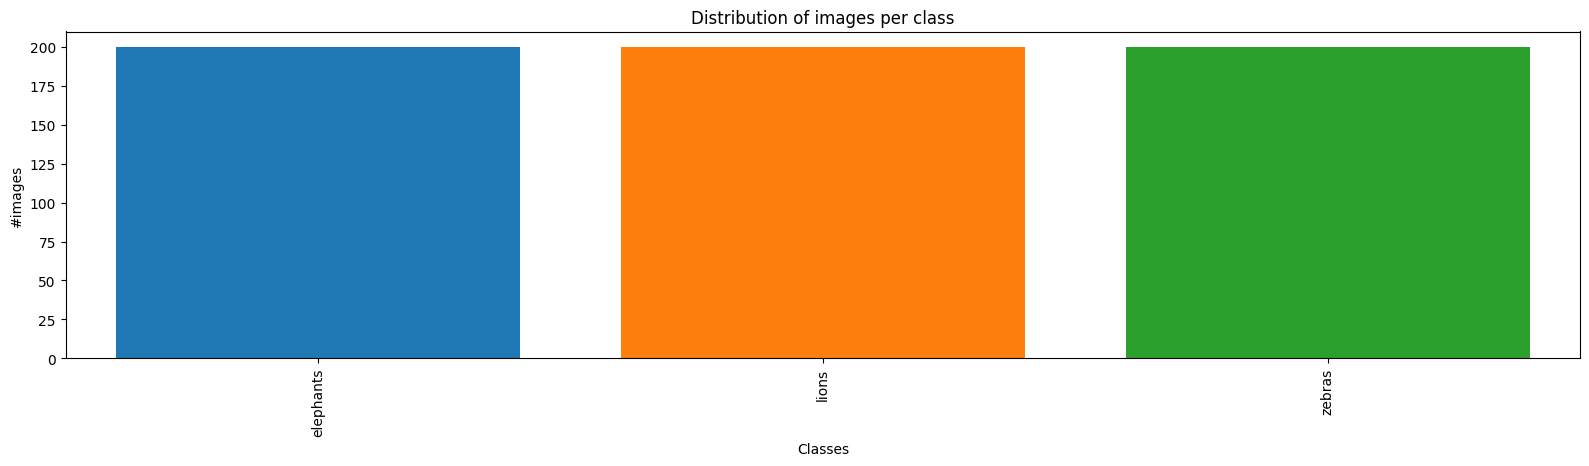

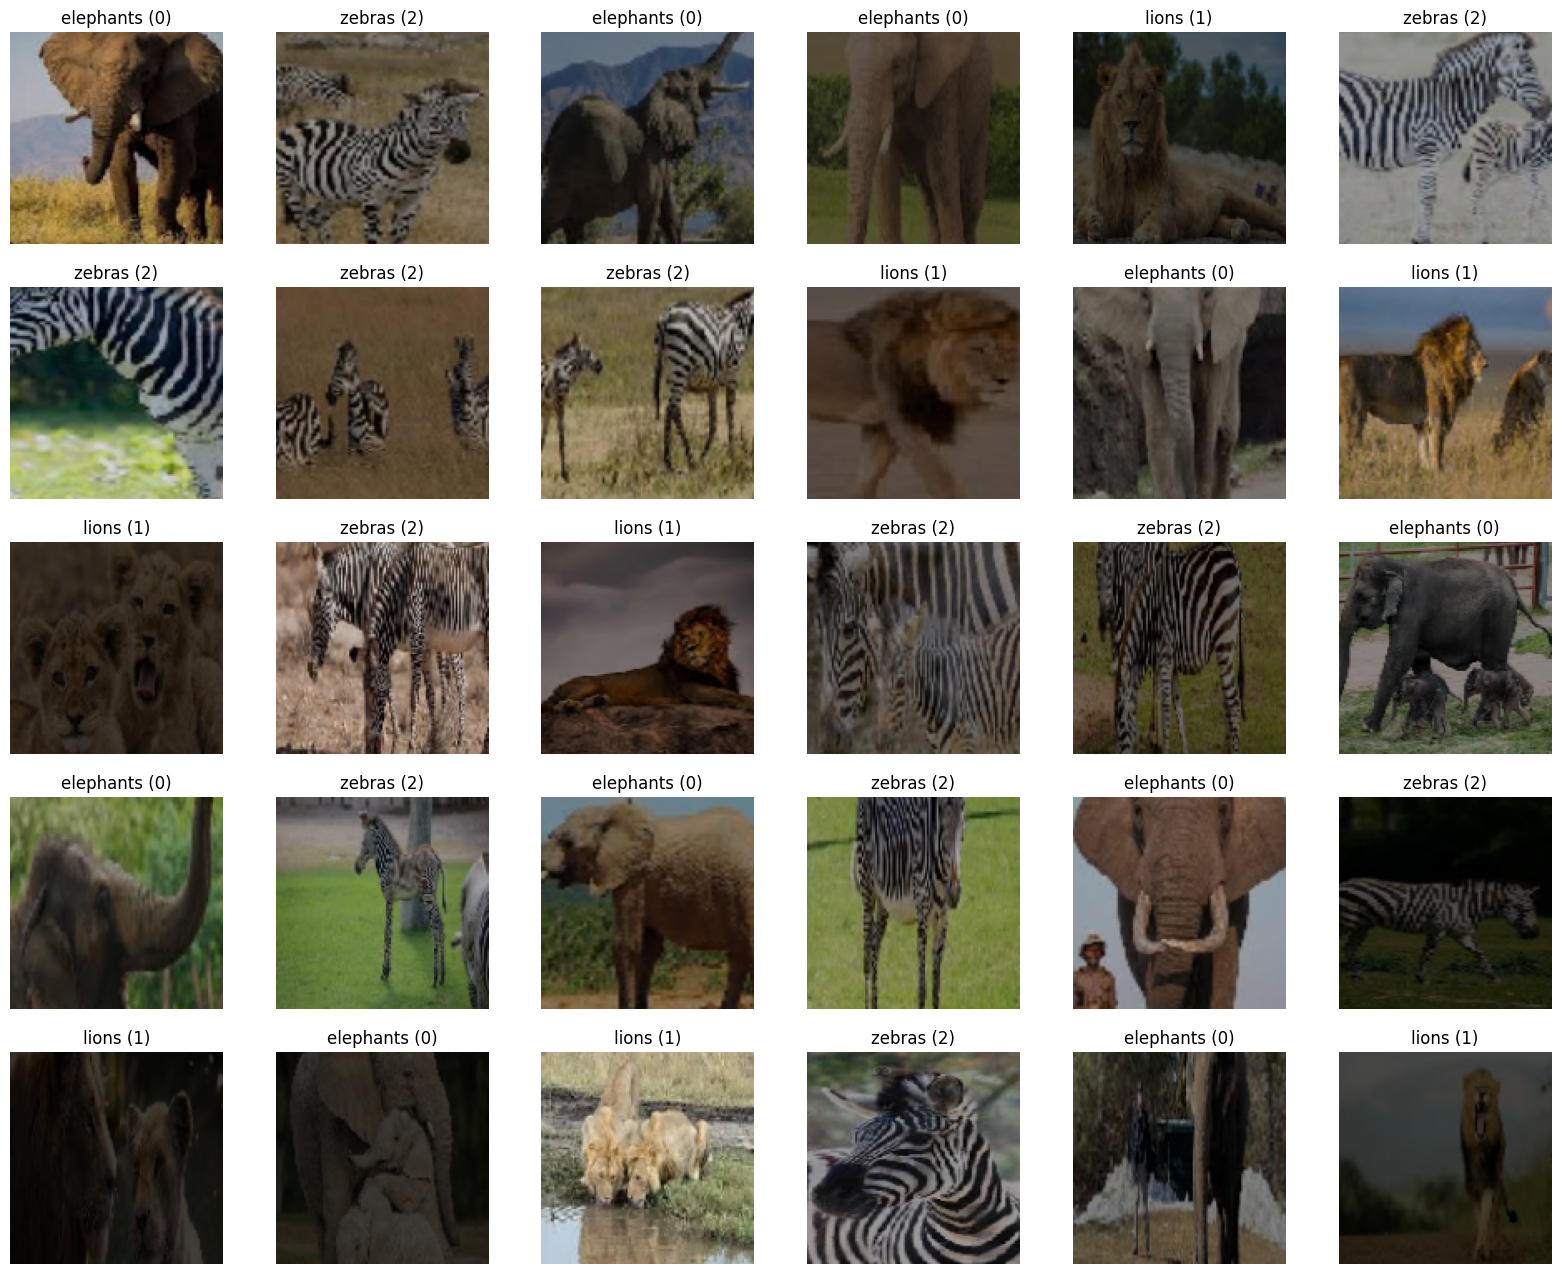

In [79]:
###############################################
#### Show distribution of images per class.
###############################################
counter=collections.Counter(train_ds.labels)
v = [ [class_names[item[0]],item[1]]  for item in counter.items()]
df = pd.DataFrame(data=v, columns=['index','value'])
g = sns.catplot(x='index', y= 'value',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class")
plt.xticks(rotation='vertical')
plt.show()

#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(20, 16))
images = []
labels = []
for itr in train_ds.next():
    for i in range(30):
        if len(images) < 30:
            images.append(itr[i].astype("uint8"))
        else:
            labels.append(list(itr[i]).index(1))

for i in range(len(images)):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]].replace('_',' ') +' ('+str(int(labels[i]))+')')
    plt.axis("off")

### Convolutional Neural Network (CNN) with several convolutional layers followed by a few fully connected (dense) layers.

In [80]:
# Defining your model here:
model = models.Sequential()
model.add(keras.Input(shape=image_size + (3,))) 
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32, (3,3), padding='SAME', activation='relu'))
model.add(layers.Conv2D(32, (3,3), padding='SAME', activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.GaussianNoise(0.1))
model.add(layers.Conv2D(64, (3,3), padding='SAME', activation='relu'))
model.add(layers.Conv2D(64, (3,3), padding='SAME', activation='relu'))
model.add(layers.MaxPool2D())
#model.add(layers.Dropout(0.2))
model.add(layers.SpatialDropout2D(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='SAME', activation='relu'))
#Dense part
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_classes, activation='softmax', activity_regularizer=tf.keras.regularizers.l2(0.001)))
# Print a summary of the model
model.summary()

# Compiling the model by defininf an optimizer, a loss function, 
# and the metrics to be used for monitoring the traning.
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.7),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                      

In [81]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.01, patience=4, min_lr=0.001)
mcp_save = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [82]:
# Start the trining by defining the number of epochs to train, the traing set and the validation set.
history = model.fit(
    train_ds, epochs = 50, batch_size=64, steps_per_epoch=round(train_ds.samples/batch_size),
                    validation_data=val_ds, validation_steps=round(val_ds.samples/batch_size), callbacks=[early_stopping, lr_on_plateu, mcp_save]
)

Epoch 1/50
9/9 [==============================] - 21s 2s/step - loss: 1.3869 - accuracy: 0.3731 - val_loss: 1.0988 - val_accuracy: 0.4609 - lr: 0.0100
Epoch 2/50
9/9 [==============================] - 20s 2s/step - loss: 1.0344 - accuracy: 0.5578 - val_loss: 1.0889 - val_accuracy: 0.3828 - lr: 0.0100
Epoch 3/50
9/9 [==============================] - 18s 2s/step - loss: 0.9275 - accuracy: 0.6287 - val_loss: 1.0775 - val_accuracy: 0.3828 - lr: 0.0100
Epoch 4/50
9/9 [==============================] - 19s 2s/step - loss: 0.8497 - accuracy: 0.6660 - val_loss: 1.0662 - val_accuracy: 0.3828 - lr: 0.0100
Epoch 5/50
9/9 [==============================] - 20s 2s/step - loss: 0.8770 - accuracy: 0.6567 - val_loss: 1.0716 - val_accuracy: 0.3828 - lr: 0.0100
Epoch 6/50
9/9 [==============================] - 19s 2s/step - loss: 0.7753 - accuracy: 0.7257 - val_loss: 1.0604 - val_accuracy: 0.3828 - lr: 0.0100
Epoch 7/50
9/9 [==============================] - 19s 2s/step - loss: 0.7440 - accuracy: 0.770

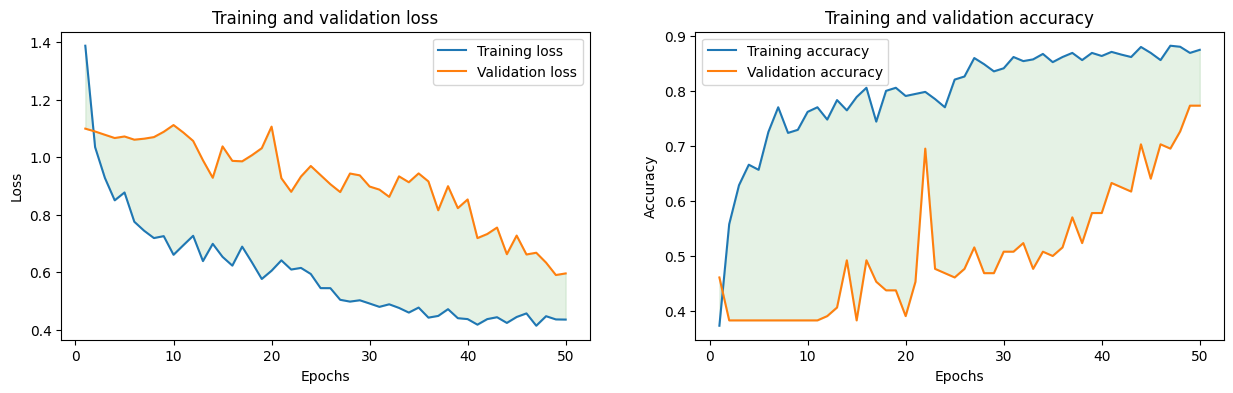

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [84]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
print(classification_report(y_true, y_pred, target_names=class_names))

3/3 [==============================] - 1s 184ms/step
              precision    recall  f1-score   support

   elephants       0.79      0.53      0.63        49
       lions       0.65      0.94      0.77        49
      zebras       0.98      0.86      0.91        49

    accuracy                           0.78       147
   macro avg       0.80      0.78      0.77       147
weighted avg       0.80      0.78      0.77       147



In [85]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    vmax = cm.max()
    if normalize:
        title = 'Confusion matrix (normalized)'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = [[int(j*100) for j in i ] for i in cm]
        cm =np.array(cm)
        vmax = 100
        
    plt.figure(figsize=(8,8))

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=vmax)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar(im,fraction=0.046, pad=0.04)

3/3 [==============================] - 1s 204ms/step


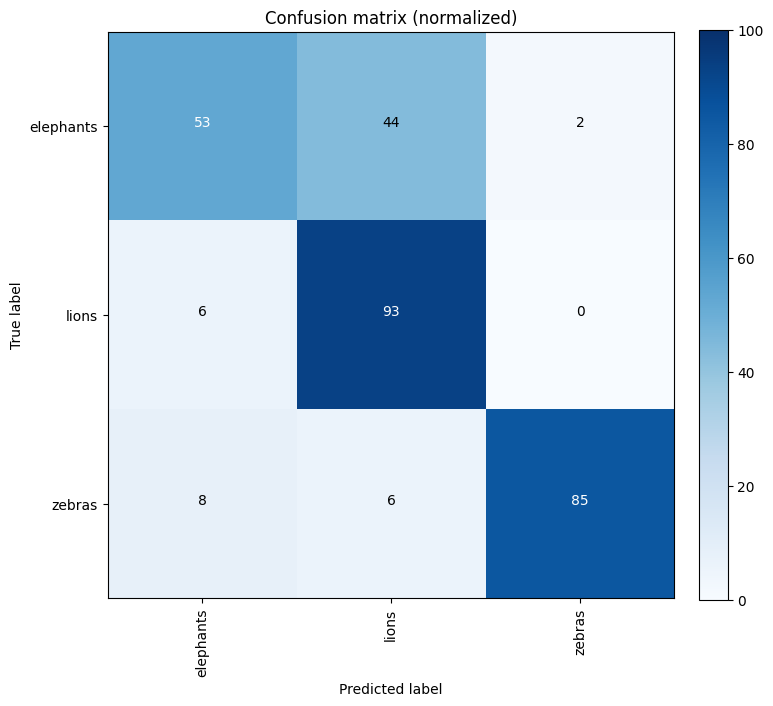

In [86]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm=cnf_matrix, classes=class_names, title='Confusion Matrix', normalize=True)

1/1 [==============================] - 0s 64ms/step


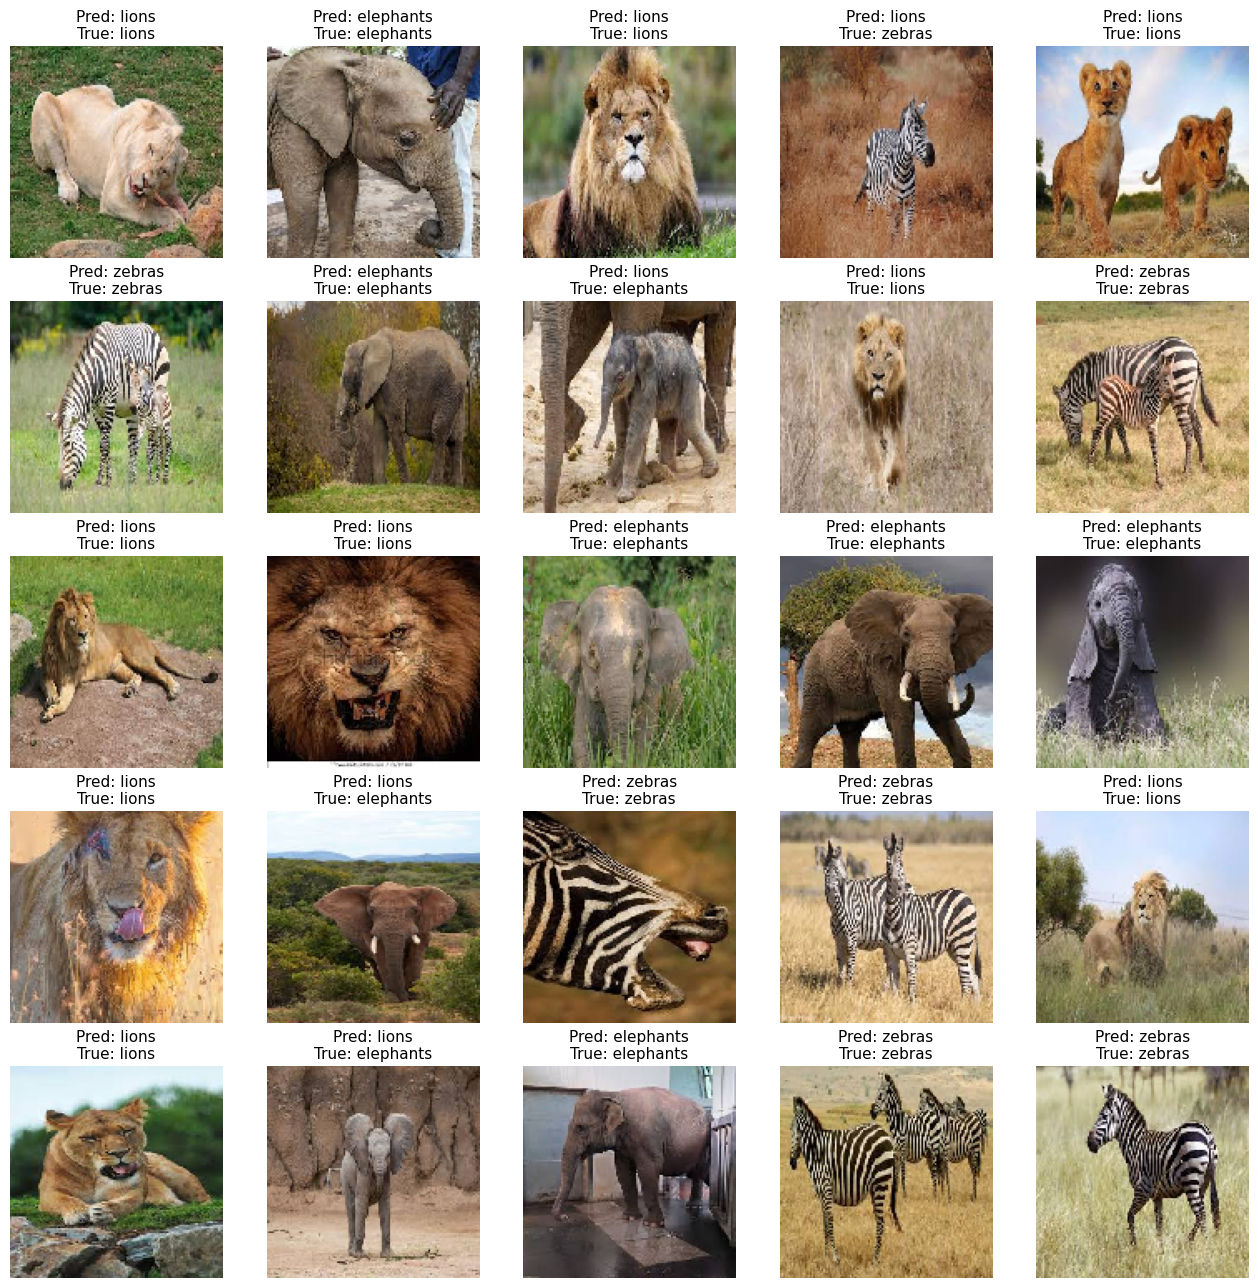

In [87]:
val_ds.reset()
val_ds.shuffle = True
#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(16, 16))
images = []
labels_pred = []
labels_true = []
for itr in val_ds.next():
    for i in range(25):
        if len(images) < 25:
            images.append(itr[i].astype("uint8"))
            y_proba = model.predict(np.array([itr[i]]))
            y_pred = np.argmax(y_proba,axis=1)[0]
            labels_pred.append(y_pred)
        else:
            labels_true.append(list(itr[i]).index(1))
    

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])    
    title = 'Pred: ' + class_names[labels_pred[i]].replace('_',' ') +'\n' +'True: ' + class_names[labels_true[i]].replace('_',' ') 
    
    
    plt.title(title,fontsize= 11, pad=5)
    plt.axis("off")
#     plt.subplots_adjust(left=None, bottom=0.1, right=None, top=1, wspace=None, hspace=None)

In [97]:
count = 0
count_predicted = 0
for i in range(len(images)):
    if (class_names[labels_pred[i]] == class_names[labels_true[i]]):
        count_predicted = count_predicted + 1
    if (class_names[labels_true[i]] == class_names[labels_true[i]]):
        count = count + 1
        
print("Sum images: ", count)
print("True Predicted: ", count_predicted)

Sum images:  25
True Predicted:  21


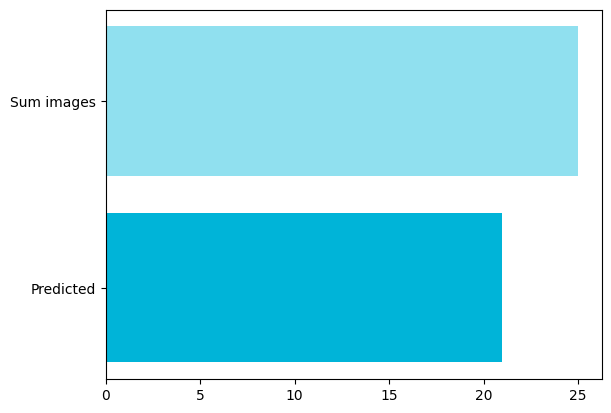

In [89]:
labels = ['Predicted', 'Sum images']
values = [count_predicted, count]
colors = ['#00b4d8', '#90e0ef']

# Create a bar chart
plt.barh(labels, values, color=colors)

# Show the plot
plt.show()

In [133]:
class_indices = train_ds.class_indices
class_indices 

{'elephants': 0, 'lions': 1, 'zebras': 2}

### VGG (Visual Geometry Group) Network

In [134]:
def VGG():
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Third convolutional block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fourth convolutional block
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fifth convolutional block
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    return model

In [135]:
model_vgg = VGG()
model_vgg.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_82 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_84 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                

In [136]:
steps_per_epoch = train_ds.samples // batch_size
print(steps_per_epoch)
validation_steps = val_ds.samples // batch_size
print(validation_steps)

9
2


In [138]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy')

# Train the model
model_vgg.fit(
        train_ds,
        epochs=50,
        steps_per_epoch=train_ds.samples // batch_size,
        validation_data=val_ds,
        validation_steps=val_ds.samples // batch_size)

Epoch 1/50
9/9 [==============================] - 81s 9s/step - loss: 145.3376 - val_loss: 1.2080
Epoch 2/50
9/9 [==============================] - 77s 9s/step - loss: 1.1028 - val_loss: 1.0991
Epoch 3/50
9/9 [==============================] - 77s 8s/step - loss: 1.0995 - val_loss: 1.0981
Epoch 4/50
9/9 [==============================] - 77s 9s/step - loss: 1.1001 - val_loss: 1.0984
Epoch 5/50
9/9 [==============================] - 77s 9s/step - loss: 1.0986 - val_loss: 1.0987
Epoch 6/50
9/9 [==============================] - 77s 8s/step - loss: 1.0992 - val_loss: 1.0985
Epoch 7/50
9/9 [==============================] - 77s 8s/step - loss: 1.0991 - val_loss: 1.0983
Epoch 8/50
9/9 [==============================] - 78s 9s/step - loss: 1.0998 - val_loss: 1.0966
Epoch 9/50
9/9 [==============================] - 77s 8s/step - loss: 1.1002 - val_loss: 1.0987
Epoch 10/50
9/9 [==============================] - 77s 9s/step - loss: 1.1000 - val_loss: 1.0986
Epoch 11/50
9/9 [====================

In [144]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [155]:
input_size = (128, 128)
def pred_func(img_path):
    # Load and show the image
    img = load_img(img_path, target_size=input_size)
    
    # Preprocess the image and make the prediction
    test_image = img_to_array(img)
    test_image = np.expand_dims(test_image, axis=0)
    result = model_vgg.predict(test_image)

    # Print the predicted class
    class_indices = train_ds.class_indices

    class_indices = train_ds.class_indices
    ind_to_class = {v:k for k,v in class_indices.items()}
    predicted_class = ind_to_class[result[0].argmax()]
    
    return predicted_class, img

In [184]:
def original_label(img_path):
    num = img_path.split('/')[-1].split('-')[-1].split('.')[0]
    num = int(num)
    if (5 > num > 0):
        return 'elephants'
    if (9 > num > 4):
        return 'lions'
    if (13 > num > 8):
        return 'zebras'

### Elephants

1/1 [==============================] - 0s 85ms/step
Original Label: elephants
Predicted class: elephants


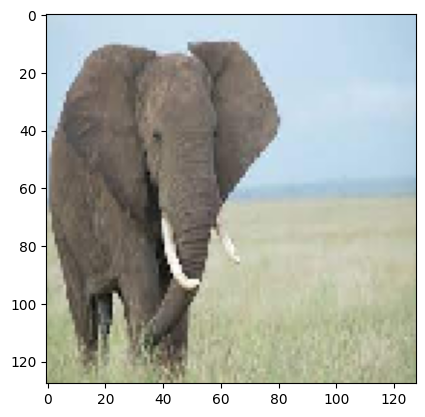

In [188]:
img_path = 'dataset/single_prediction/image-01.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 80ms/step
Original Label: elephants
Predicted class: elephants


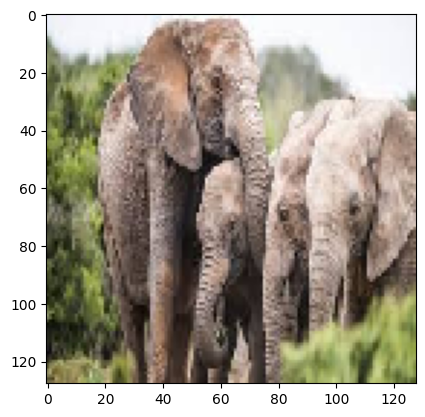

In [189]:
img_path = 'dataset/single_prediction/image-02.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 76ms/step
Original Label: elephants
Predicted class: lions


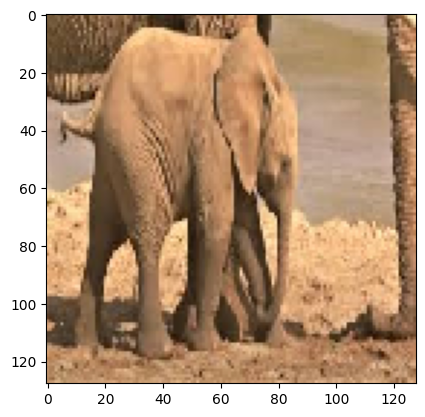

In [190]:
img_path = 'dataset/single_prediction/image-03.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 76ms/step
Original Label: elephants
Predicted class: elephants


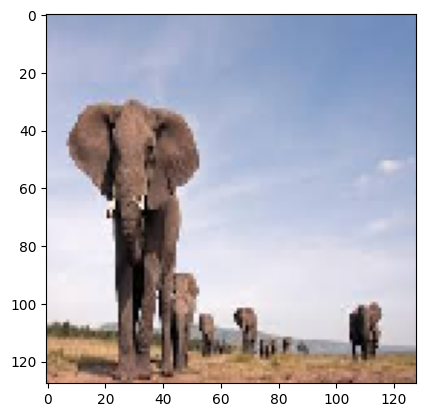

In [191]:
img_path = 'dataset/single_prediction/image-04.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

### Lions

1/1 [==============================] - 0s 75ms/step
Original Label: lions
Predicted class: lions


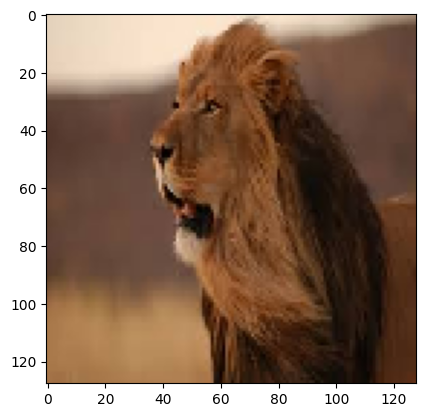

In [192]:
img_path = 'dataset/single_prediction/image-05.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 82ms/step
Original Label: lions
Predicted class: lions


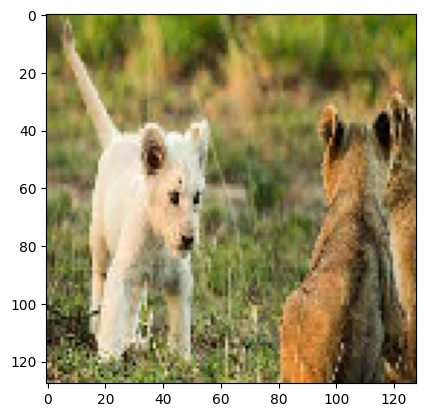

In [193]:
img_path = 'dataset/single_prediction/image-06.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 78ms/step
Original Label: lions
Predicted class: lions


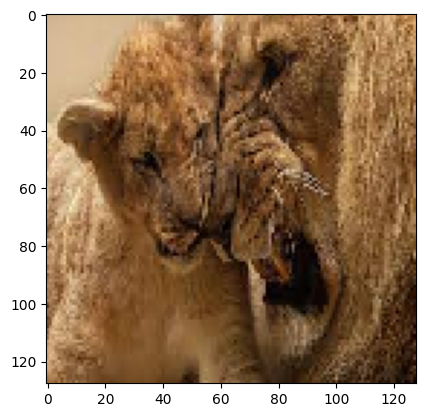

In [194]:
img_path = 'dataset/single_prediction/image-07.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 77ms/step
Original Label: lions
Predicted class: elephants


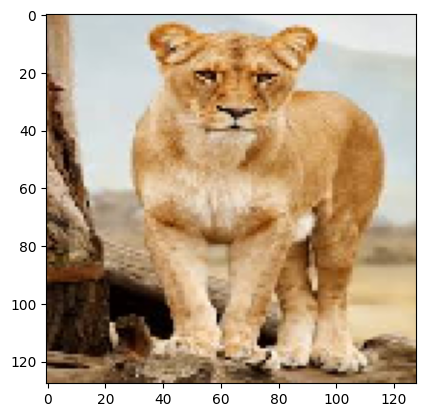

In [195]:
img_path = 'dataset/single_prediction/image-08.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

### Zebras

1/1 [==============================] - 0s 79ms/step
Original Label: zebras
Predicted class: zebras


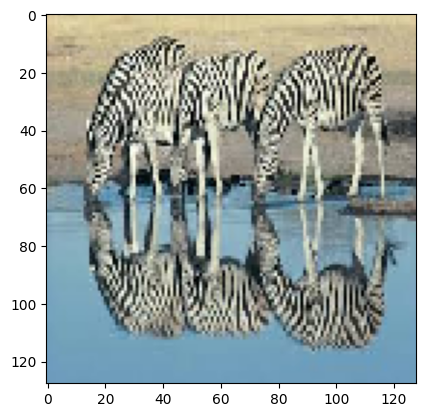

In [196]:
img_path = 'dataset/single_prediction/image-09.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 77ms/step
Original Label: zebras
Predicted class: zebras


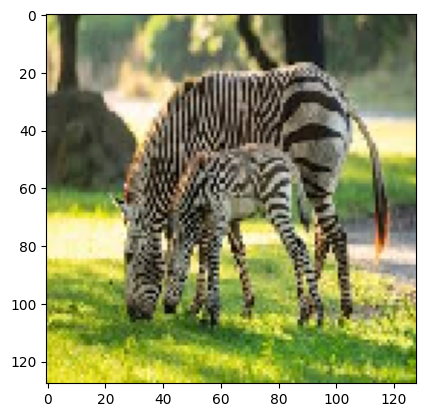

In [197]:
img_path = 'dataset/single_prediction/image-10.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 83ms/step
Original Label: zebras
Predicted class: zebras


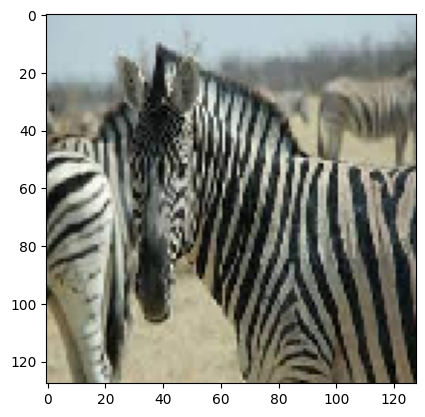

In [198]:
img_path = 'dataset/single_prediction/image-11.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

1/1 [==============================] - 0s 82ms/step
Original Label: zebras
Predicted class: zebras


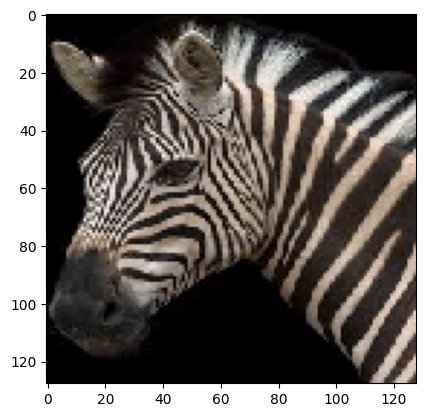

In [199]:
img_path = 'dataset/single_prediction/image-12.jpg'
res, img = pred_func(img_path)
print("Original Label:", original_label(img_path))
print("Predicted class:", res)
plt.imshow(img)

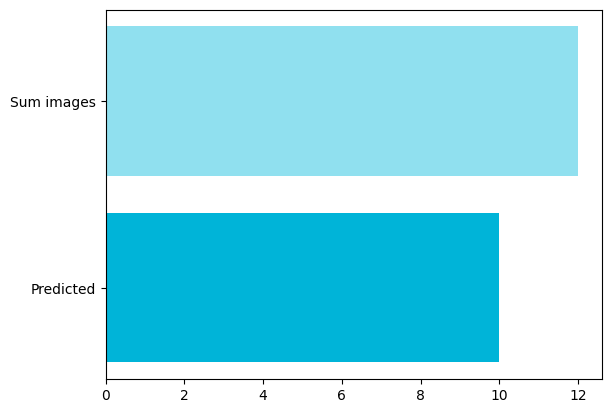

In [201]:
labels = ['Predicted', 'Sum images']
values = [10, 12]
colors = ['#00b4d8', '#90e0ef']

# Create a bar chart
plt.barh(labels, values, color=colors)

# Show the plot
plt.show()